Sistem Rekomendasi Olahraga (Hybrid CF + CBF)
------------------------------------------------------
Dokumentasi ini menjelaskan alur:
1. Import library
2. Muat dataset
3. Pra-proses data (gabung, hitung kalori, encoding)
4. Membangun dan melatih model hybrid (Deep Learning)
5. Membangun matriks Content-Based (TF-IDF + Cosine)
6. Menghasilkan rekomendasi hybrid

# Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt
import pickle

# Data Loading

In [2]:
base_url = "https://raw.githubusercontent.com/hilmanfaujiabdilah/capstone-rekomendasi-olahraga/refs/heads/main/dataset%20olahraga"
olahraga = pd.read_csv(f"{base_url}/olahraga.csv")
history = pd.read_csv(f"{base_url}/history_olahraga.csv")
user = pd.read_csv(f"{base_url}/user_dataset.csv")

# Data Preprocessing

In [3]:
# Menggabungkan dataset
df = history.merge(user, on='id_user').merge(olahraga, on='id_olahraga')

# Menghitung kalori yang terbakat
df['kalori_terbakar'] = (df['durasi_menit'] / 60) * df['kalori_jam']

# Simpan encoder untuk inference
user_le = LabelEncoder()
olahraga_le = LabelEncoder()
df['user_encoded'] = user_le.fit_transform(df['id_user'])
df['olahraga_encoded'] = olahraga_le.fit_transform(df['id_olahraga'])

# Melakukan one hot encoding pada fitur categorical
df = pd.get_dummies(df, columns=['aktivitas_harian', 'rutin_olahraga'])

# Melakukan normalisasi pada fitur numerical
scaler = MinMaxScaler()
df[['durasi_normal', 'kalori_normal']] = scaler.fit_transform(df[['durasi_menit', 'kalori_terbakar']])

# Modeling

In [4]:
model = Sequential()
model.add(layers.Input(shape=(2,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [5]:
fitur_input = ['user_encoded', 'olahraga_encoded']
X = df[fitur_input].values
y = df['kalori_normal'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
history_fit = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=20, batch_size=8,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2663.2461 - mse: 2663.2461 - rmse: 49.6022 - val_loss: 56.6079 - val_mse: 56.6079 - val_rmse: 7.5238
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 96.0416 - mse: 96.0416 - rmse: 9.7667 - val_loss: 0.4046 - val_mse: 0.4046 - val_rmse: 0.6361
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 32.5080 - mse: 32.5080 - rmse: 5.6942 - val_loss: 0.3169 - val_mse: 0.3169 - val_rmse: 0.5629
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.0926 - mse: 16.0926 - rmse: 3.9922 - val_loss: 1.0913 - val_mse: 1.0913 - val_rmse: 1.0446
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.4246 - mse: 9.4246 - rmse: 3.0536 - val_loss: 1.0589 - val_mse: 1.0589 - val_rmse: 1.0290
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1385 - mse: 5.1385 - rmse: 2.2617 - val_loss: 0.0505 - val_mse: 0.0505 - val_rmse: 0.2248
Epoch 7/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6052 - mse:

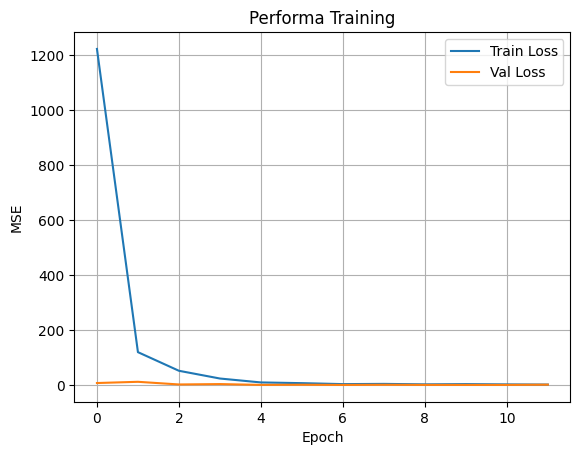

In [ ]:
plt.plot(history_fit.history['loss'], label='Train Loss')
plt.plot(history_fit.history['val_loss'], label='Val Loss')
plt.title("Performa Training")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
olahraga['combined'] = olahraga['latihan'] + " " + olahraga['kalori_jam'].astype(str)
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(olahraga['combined'])
cbf_matrix = cosine_similarity(tfidf_matrix)
cbf_df = pd.DataFrame(cbf_matrix, index=olahraga['id_olahraga'], columns=olahraga['id_olahraga'])

# Melakukan Test Rekomendasi

In [ ]:
def recommend_hybrid(user_id, top_k=5, alpha=0.7):
    """
    Menghasilkan rekomendasi hybrid (CF + CBF) untuk user yang dikenal,
    atau rekomendasi Content-Based jika user baru.

    Parameter:
    - user_id: ID user (int)
    - top_k: jumlah rekomendasi teratas
    - alpha: rasio bobot CF dan CBF (hanya untuk user lama)

    Output: DataFrame dengan kolom:
    - id_olahraga, latihan, rata_durasi_menit, rata_kalori_terbakar
    """

    # Cek apakah user dikenal oleh encoder
    is_user_known = user_id in user_le.classes_

    visited_items = history.loc[history['id_user'] == user_id, 'id_olahraga'].unique() if is_user_known else []
    all_ol_ids = olahraga['id_olahraga'].unique().tolist()
    candidates = [oid for oid in all_ol_ids if oid not in visited_items]
    n_cand = len(candidates)

    # if n_cand == 0:
    #     return pd.DataFrame(columns=['id_olahraga', 'latihan', 'rata_durasi_menit', 'rata_kalori_terbakar'])

    # Mapping encode olahraga
    olahraga_encoded_map = dict(zip(olahraga['id_olahraga'], olahraga_le.transform(olahraga['id_olahraga'])))

    # Jika user dikenal → gunakan hybrid
    if is_user_known:
        user_encoded = user_le.transform([user_id])[0]
        X_cand = np.array([[user_encoded, olahraga_encoded_map.get(oid, 0)] for oid in candidates])

        # Prediksi CF
        cf_preds = model.predict(X_cand, verbose=0).flatten()
        cf_norm = (cf_preds - cf_preds.min()) / (cf_preds.max() - cf_preds.min()) if cf_preds.max() > cf_preds.min() else np.zeros_like(cf_preds)

        # Prediksi CBF
        cb_scores = np.array([
            cbf_df.loc[oid, visited_items].mean() if oid in cbf_df.index else 0.0
            for oid in candidates
        ])
        cb_norm = (cb_scores - cb_scores.min()) / (cb_scores.max() - cb_scores.min()) if cb_scores.max() > cb_scores.min() else np.zeros_like(cb_scores)

        # Skor hybrid
        hybrid_scores = alpha * cf_norm + (1 - alpha) * cb_norm

    else:
        # Untuk user baru: gunakan hanya CBF (tanpa CF)
        cb_scores = cbf_df[candidates].mean(axis=1).values
        cb_norm = (cb_scores - cb_scores.min()) / (cb_scores.max() - cb_scores.min()) if cb_scores.max() > cb_scores.min() else np.zeros_like(cb_scores)
        hybrid_scores = cb_norm  # 100% dari CBF

    # Ambil top-k
    top_idx = np.argsort(hybrid_scores)[-top_k:][::-1]
    top_oids = [candidates[i] for i in top_idx]

    avg_durasi = history.groupby('id_olahraga')['durasi_menit'].mean().to_dict()
    kalori_jam = olahraga.set_index('id_olahraga')['kalori_jam'].to_dict()

    results = []
    for i, oid in enumerate(top_oids):
        nama_latihan = olahraga.loc[olahraga['id_olahraga'] == oid, 'latihan'].values[0]
        durasi_rata = avg_durasi.get(oid, 30.0)  # fallback: 30 menit
        kalori_rata = (durasi_rata / 60) * kalori_jam.get(oid, 0.0)
        results.append({
            'id_olahraga': oid,
            'latihan': nama_latihan,
            'rata_durasi_menit': round(durasi_rata, 1),
            'rata_kalori_terbakar': round(kalori_rata, 1)
        })

    return pd.DataFrame(results)

In [ ]:
# Untuk user lama:
rekomendasi = recommend_hybrid(user_id=10)
print(rekomendasi)

   id_olahraga                 latihan  rata_durasi_menit  \
0          136  Bola Tangan (Handball)               58.8   
1          156        Lari - 16 km/jam               62.1   
2          155      Lari - 14,5 km/jam               60.6   
3          154        Lari - 13 km/jam               73.2   
4          144                   Padel               63.6   

   rata_kalori_terbakar  
0                 576.4  
1                1216.2  
2                1113.5  
3                1211.1  
4                 623.7  


# Menyimpan Model

In [ ]:
model.save("model_hybrid.h5")
print("Model disimpan ke model_hybrid.h5")

Model disimpan ke model_hybrid.h5


# Inference Code

### Import Library

In [ ]:
import numpy as np
import pandas as pd
import pickle
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

### Load Model dan data pendukung

In [ ]:
model = keras.models.load_model("model_hybrid.h5")

In [ ]:
# Load dataset (jika di deploy, datanya di ambil dari database)
base_url = "https://raw.githubusercontent.com/hilmanfaujiabdilah/capstone-rekomendasi-olahraga/refs/heads/main/dataset%20olahraga"
olahraga = pd.read_csv(f"{base_url}/olahraga.csv")
history = pd.read_csv(f"{base_url}/history_olahraga.csv")
user = pd.read_csv(f"{base_url}/user_dataset.csv")

In [ ]:
# Membuat matrix cbf baru, untuk rekomendasi content based filtering
olahraga['combined'] = olahraga['latihan'] + " " + olahraga['kalori_jam'].astype(str)
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(olahraga['combined'])
cbf_df = pd.DataFrame(
    cosine_similarity(tfidf_matrix),
    index=olahraga['id_olahraga'],
    columns=olahraga['id_olahraga']
)

In [ ]:
# Melakukan encoder pada data yang di ambil dari datase
def load_and_prepare_encoders():
    user_le = LabelEncoder()
    olahraga_le = LabelEncoder()
    user_le.fit(history['id_user'])
    olahraga_le.fit(olahraga['id_olahraga'])
    return user_le, olahraga_le

In [ ]:
# Fungsi Rekomendasi
def recommend(user_id=None, aktivitas_harian=None, rutin_olahraga=None, top_k=5, alpha=0.7):
    user_le, olahraga_le = load_and_prepare_encoders()
    all_ol_ids = olahraga['id_olahraga'].tolist()

    # Mapping encode olahraga
    olahraga_encoded_map = dict(zip(olahraga['id_olahraga'], olahraga_le.transform(olahraga['id_olahraga'])))

    # Apakah user_id tersedia dan valid?
    is_user_known = user_id in user_le.classes_ if user_id is not None else False

    if is_user_known:
        # === Rekomendasi HYBRID ===
        visited = history[history['id_user'] == user_id]['id_olahraga'].unique()
        candidates = [oid for oid in all_ol_ids if oid not in visited]

        if not candidates:
            return pd.DataFrame(columns=['latihan', 'rata_durasi_menit', 'rata_kalori_terbakar'])

        user_encoded = user_le.transform([user_id])[0]
        # Ensure that the encoded olahraga ID is in the map before accessing it
        X = np.array([[user_encoded, olahraga_encoded_map.get(oid, 0)] for oid in candidates])


        cf_preds = model.predict(X, verbose=0).flatten()
        cf_norm = (cf_preds - cf_preds.min()) / (cf_preds.max() - cf_preds.min()) if cf_preds.max() > cf_preds.min() else np.zeros_like(cf_preds)

        # Ensure visited items are in the cbf_df index/columns
        valid_visited = [v for v in visited if v in cbf_df.index and v in cbf_df.columns]

        cb_scores = np.array([
            cbf_df.loc[oid, valid_visited].mean() if oid in cbf_df.index and len(valid_visited) > 0 else 0.0
            for oid in candidates
        ])
        cb_norm = (cb_scores - cb_scores.min()) / (cb_scores.max() - cb_scores.min()) if cb_scores.max() > cb_scores.min() else np.zeros_like(cb_scores)

        hybrid_scores = alpha * cf_norm + (1 - alpha) * cb_norm
        ranked_oids = [candidates[i] for i in np.argsort(hybrid_scores)[-top_k:][::-1]]

    else:
        # === Rekomendasi User Baru Berdasarkan Profil Serupa ===
        # FIX: Change user_df to user
        subset = user[
            (user['aktivitas_harian'] == aktivitas_harian) &
            (user['rutin_olahraga'] == rutin_olahraga)
        ]

        similar_users = subset['id_user'].values
        if len(similar_users) == 0:
            # If no similar users, perhaps recommend the most popular items overall
            # or return empty. Returning empty for now as per original code structure.
            return pd.DataFrame(columns=['latihan', 'rata_durasi_menit', 'rata_kalori_terbakar'])

        temp_history = history[history['id_user'].isin(similar_users)]

        if temp_history.empty:
             # If similar users have no history, return empty or popular items
             return pd.DataFrame(columns=['latihan', 'rata_durasi_menit', 'rata_kalori_terbakar'])


        top_ids = temp_history['id_olahraga'].value_counts().head(top_k).index.tolist()
        ranked_oids = top_ids

    # === Format Hasil ===
    # Ensure 'id_olahraga' exists in history before grouping
    if 'id_olahraga' in history.columns:
        avg_durasi = history.groupby('id_olahraga')['durasi_menit'].mean().to_dict()
    else:
         avg_durasi = {} # Default empty if column missing

    # Ensure 'id_olahraga' and 'kalori_jam' exist in olahraga
    if 'id_olahraga' in olahraga.columns and 'kalori_jam' in olahraga.columns:
        kalori_jam = olahraga.set_index('id_olahraga')['kalori_jam'].to_dict()
    else:
        kalori_jam = {} # Default empty if columns missing


    results = []
    for oid in ranked_oids:
        # Ensure oid exists in olahraga before accessing
        if oid in olahraga['id_olahraga'].values:
             nama_latihan = olahraga.loc[olahraga['id_olahraga'] == oid, 'latihan'].values[0]
             durasi = avg_durasi.get(oid, 30.0)
             kalori = (durasi / 60) * kalori_jam.get(oid, 0.0)
             results.append({
                 'id_olahraga': oid,
                 'latihan': nama_latihan,
                 'rata_durasi_menit': round(durasi, 1),
                 'rata_kalori_terbakar': round(kalori, 1)
             })
        # Optionally handle case where oid is not found in olahraga data


    return pd.DataFrame(results)

In [ ]:
if __name__ == "__main__":
    # User lama
    print("Rekomendasi user lama (jika ID tersedia):")
    rekom1 = recommend(user_id=10)
    print(rekom1)

    # User baru
    print("\nRekomendasi user baru (berdasarkan aktivitas dan kebiasaan):")
    rekom2 = recommend(aktivitas_harian="sedang", rutin_olahraga="sering")
    print(rekom2)

Rekomendasi user lama (jika ID tersedia):
   id_olahraga                 latihan  rata_durasi_menit  \
0          136  Bola Tangan (Handball)               58.8   
1          156        Lari - 16 km/jam               62.1   
2          155      Lari - 14,5 km/jam               60.6   
3          154        Lari - 13 km/jam               73.2   
4          144                   Padel               63.6   

   rata_kalori_terbakar  
0                 576.4  
1                1216.2  
2                1113.5  
3                1211.1  
4                 623.7  

Rekomendasi user baru (berdasarkan aktivitas dan kebiasaan):
   id_olahraga               latihan  rata_durasi_menit  rata_kalori_terbakar
0           76                   Gym               61.8                 454.4
1           82               Aerobik               67.0                 573.7
2           30  Sepeda Motor Listrik               65.2                 239.2
3          129              Spinning               62.8      